<a href="https://www.kaggle.com/code/averma111/pytorch-cafa-5-prediction?scriptVersionId=130466757" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [67]:
import os
import gc
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
tqdm.pandas()
import torch
import warnings
warnings.filterwarnings('ignore')


In [68]:
def get_dataframe(path):
    return pd.read_csv(path,sep='\t')

In [69]:
train_terms = '/kaggle/input/cafa-5-protein-function-prediction/Train/train_terms.tsv'
train_taxonomy ='/kaggle/input/cafa-5-protein-function-prediction/Train/train_taxonomy.tsv'

In [70]:
get_dataframe(train_terms).head()

,EntryID,term,aspect
0,A0A009IHW8,GO:0008152,BPO
1,A0A009IHW8,GO:0034655,BPO
2,A0A009IHW8,GO:0072523,BPO
3,A0A009IHW8,GO:0044270,BPO
4,A0A009IHW8,GO:0006753,BPO


In [71]:
get_dataframe(train_taxonomy).head()


,EntryID,taxonomyID
0,Q8IXT2,9606
1,Q04418,559292
2,A8DYA3,7227
3,Q9UUI3,284812
4,Q57ZS4,185431


In [72]:
def summary(text, df):
    print(f'{text} shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summ['null'] = df.isnull().sum()
    summ['unique'] = df.nunique()
    summ['min'] = df.min()
    summ['median'] = df.median()
    summ['max'] = df.max()
    summ['mean'] = df.mean()
    summ['std'] = df.std()
    summ['duplicate'] = df.duplicated().sum()
    return summ

In [73]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [74]:
summary('train_terms',reduce_mem_usage(get_dataframe(train_terms)))

Memory usage of dataframe is 122.77 MB
Memory usage after optimization is: 42.17 MB
Decreased by 65.6%
train_terms shape: (5363863, 3)


,dtypes,null,unique,min,median,max,mean,std,duplicate
EntryID,category,0,142246,NaN,NaN,NaN,NaN,NaN,0
term,category,0,31466,NaN,NaN,NaN,NaN,NaN,0
aspect,category,0,3,NaN,NaN,NaN,NaN,NaN,0


In [75]:
summary('train_terms',reduce_mem_usage(get_dataframe(train_taxonomy)))

Memory usage of dataframe is 2.17 MB
Memory usage after optimization is: 6.20 MB
Decreased by -185.7%
train_terms shape: (142246, 2)


,dtypes,null,unique,min,median,max,mean,std,duplicate
EntryID,category,0,142246,NaN,NaN,NaN,NaN,NaN,0
taxonomyID,int32,0,3156,24.0,9606.0,2902295.0,76300.078814,173917.278619,0


Memory usage of dataframe is 122.77 MB
Memory usage after optimization is: 42.17 MB
Decreased by 65.6%


<AxesSubplot: xlabel='aspect', ylabel='count'>

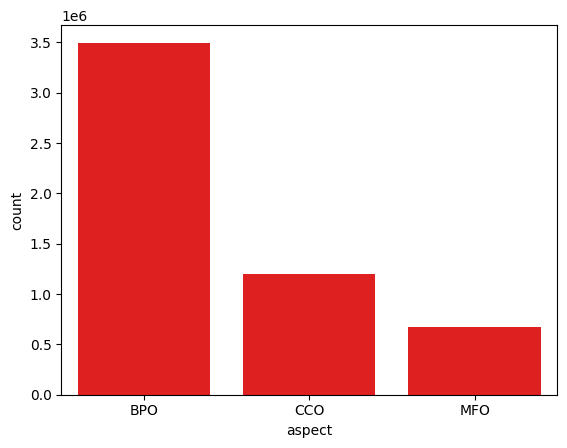

In [76]:
sns.countplot(data=reduce_mem_usage(get_dataframe(train_terms)),x='aspect',color='r')

In [77]:
terms = reduce_mem_usage(get_dataframe(train_terms)).groupby(['aspect', 'term'])['term'].count().reset_index(name='frequency')
terms.groupby('aspect')['term'].nunique()

Memory usage of dataframe is 122.77 MB
Memory usage after optimization is: 42.17 MB
Decreased by 65.6%


aspect
BPO    31466
CCO    31466
MFO    31466
Name: term, dtype: int64

In [79]:
fractions = (terms.groupby('aspect')['term'].nunique() / terms['term'].nunique() * 1500).apply(round)
print(fractions)

aspect
BPO    1500
CCO    1500
MFO    1500
Name: term, dtype: int64


In [82]:
final_terms = set()
for aspect, number in fractions.items():
    final_terms = terms.loc[(terms.aspect == aspect)]
    final_terms = final_terms.nlargest(number, columns='frequency', keep='first')
    final_terms.update(final_terms.term.to_list())
    


<class 'set'>


In [84]:
def assign_labels(annotate,final_terms =set(final_terms)):
    intersection = final_terms.intersection(annotate)
    labels = np.isin(np.array(list(final_terms)), np.array(list(intersection)))
    return list(labels.astype('int'))

annotate = reduce_mem_usage(get_dataframe(train_terms)).groupby('EntryID')['term'].apply(set)
labels = annotate.progress_apply(assign_labels)

Memory usage of dataframe is 122.77 MB
Memory usage after optimization is: 42.17 MB
Decreased by 65.6%


  0%|          | 0/142246 [00:00<?, ?it/s]

In [86]:
train_ids = np.load('/kaggle/input/t5embeds/train_ids.npy')
X = np.load('/kaggle/input/t5embeds/train_embeds.npy')
y = np.array(labels[train_ids].to_list())

(array([ 0.04948843, -0.03293516,  0.03247323, ..., -0.04353154,
         0.0964628 ,  0.07306959]),
 array([0, 0, 0]))